In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from collections import deque
import gymnasium as gym
from gymnasium import spaces

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
"""
Complete Warehouse Environment
1 Dispatcher + 2 Acceptors

"""

import gymnasium as gym
from gymnasium import spaces
import numpy as np
from collections import deque
class WarehouseTaskAllocationEnv(gym.Env):
    """
    Multi-Agent Warehouse Environment
    Architecture: 1 Dispatcher + 2 Acceptors (one per station)
    """

    def __init__(self):
        super().__init__()

        # === BASIC PARAMETERS ===
        self.num_stations = 2
        self.max_queue_length = 10
        self.max_processing_time = 5
        self.station_capacity = 2
        self.arrival_rate = 0.7
        self.episode_length = 50

        # === TRACKING VARIABLES ===
        self.current_step = None
        self.station_queues = None
        self.station_processing = None
        self.pending_job = None

        # === METRICS ===
        self.total_jobs_arrived = 0
        self.total_jobs_completed = 0
        self.total_jobs_rejected = 0
        self.wait_times = []

        print("✓ Environment initialized!")
        print(f"  Architecture: 1 Dispatcher + {self.num_stations} Acceptors")

        # === DEFINE SPACES ===
        obs_dim = self.num_stations * 3 + 1
        self.observation_space = spaces.Box(
            low=0,
            high=max(self.max_queue_length, self.max_processing_time, self.station_capacity),
            shape=(obs_dim,),
            dtype=np.float32
        )

        self.dispatcher_action_space = spaces.Discrete(self.num_stations + 1)
        self.acceptor_action_space = spaces.Discrete(2)

        print(f"   Observation space: {self.observation_space.shape}")
        print(f"   Dispatcher: {self.dispatcher_action_space.n} actions")
        print(f"   Each Acceptor: {self.acceptor_action_space.n} actions")

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            np.random.seed(seed)

        self.station_queues = [deque() for _ in range(self.num_stations)]
        self.station_processing = [[] for _ in range(self.num_stations)]

        self.current_step = 0
        self.pending_job = None

        self.total_jobs_arrived = 0
        self.total_jobs_completed = 0
        self.total_jobs_rejected = 0
        self.wait_times = []

        if np.random.random() < self.arrival_rate:
            self._generate_job()

        observation = self._get_observation()
        info = self._get_info()

        return observation, info

    def step(self, actions):
        dispatcher_action = actions['dispatcher']
        acceptor_0_action = actions['acceptor_0']
        acceptor_1_action = actions['acceptor_1']

        reward = 0

        # STEP 1: Route pending job
        if self.pending_job is not None:
            if dispatcher_action >= self.num_stations:
                self.total_jobs_rejected += 1
                self.pending_job = None
                reward -= 2
            else:
                target_station = dispatcher_action

                if target_station == 0:
                    acceptor_decision = acceptor_0_action
                else:
                    acceptor_decision = acceptor_1_action

                if acceptor_decision == 1:
                    if len(self.station_queues[target_station]) < self.max_queue_length:
                        self.station_queues[target_station].append(self.pending_job)
                        self.pending_job = None
                        reward += 1

                        # === LOAD BALANCING: Bonus for routing to shorter queue ===
                        other_station = 1 - target_station
                        if len(self.station_queues[target_station]) <= len(self.station_queues[other_station]):
                            reward += 0.5  # Bonus for good routing decision

                    else:
                        self.total_jobs_rejected += 1
                        self.pending_job = None
                        reward -= 5
                else:
                    self.total_jobs_rejected += 1
                    self.pending_job = None
                    reward -= 2

        # STEP 2: Process jobs
        for station_idx in range(self.num_stations):
            while (len(self.station_processing[station_idx]) < self.station_capacity and
                  len(self.station_queues[station_idx]) > 0):
                job = self.station_queues[station_idx].popleft()
                job['remaining_time'] = job['processing_time']
                job['start_processing_time'] = self.current_step
                self.station_processing[station_idx].append(job)

            completed_jobs = []
            for job in self.station_processing[station_idx]:
                job['remaining_time'] -= 1

                if job['remaining_time'] <= 0:
                    completed_jobs.append(job)
                    wait_time = job['start_processing_time'] - job['arrival_time']
                    self.wait_times.append(wait_time)
                    self.total_jobs_completed += 1
                    reward += 10

            for job in completed_jobs:
                self.station_processing[station_idx].remove(job)

        # STEP 3: Penalize congestion
        for station_idx in range(self.num_stations):
            queue_len = len(self.station_queues[station_idx])
            if queue_len > 0.7 * self.max_queue_length:
                penalty = queue_len * 0.8
                reward -= penalty

        # === STEP 3.5: Penalize queue imbalance ===
        q0, q1 = len(self.station_queues[0]), len(self.station_queues[1])
        queue_diff = abs(q0 - q1)
        if queue_diff > 2:
            reward -= 0.3 * queue_diff

        # STEP 4: Generate new job
        if np.random.random() < self.arrival_rate:
            self._generate_job()

        # STEP 5: Increment time
        self.current_step += 1

        # STEP 6: Check termination
        terminated = False
        truncated = self.current_step >= self.episode_length

        observation = self._get_observation()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    def _generate_job(self):
        job = {
            'id': self.total_jobs_arrived,
            'processing_time': np.random.randint(1, self.max_processing_time + 1),
            'remaining_time': None,
            'arrival_time': self.current_step,
            'start_processing_time': None,
        }

        self.pending_job = job
        self.total_jobs_arrived += 1

    def _get_observation(self):
        obs = []

        for i in range(self.num_stations):
            queue_len = len(self.station_queues[i])
            num_processing = len(self.station_processing[i])

            if self.station_processing[i]:
                avg_remaining = np.mean([job['remaining_time']
                                        for job in self.station_processing[i]])
            else:
                avg_remaining = 0

            obs.extend([queue_len, num_processing, avg_remaining])

        pending_flag = 1 if self.pending_job is not None else 0
        obs.append(pending_flag)

        return np.array(obs, dtype=np.float32)

    def _get_info(self):
        return {
            'current_step': self.current_step,
            'total_jobs_arrived': self.total_jobs_arrived,
            'total_jobs_completed': self.total_jobs_completed,
            'total_jobs_rejected': self.total_jobs_rejected,
            'queue_lengths': [len(q) for q in self.station_queues],
            'avg_wait_time': np.mean(self.wait_times) if self.wait_times else 0,
        }


In [ ]:
class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, action_dim)

        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
            nn.init.constant_(layer.bias, 0)
        nn.init.orthogonal_(self.fc_out.weight, gain=0.01)
        nn.init.constant_(self.fc_out.bias, 0)

    def forward(self, state):
        x = torch.tanh(self.fc1(state))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return self.fc_out(x)


class CriticNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=128):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)

        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
            nn.init.constant_(layer.bias, 0)
        nn.init.orthogonal_(self.fc_out.weight, gain=1.0)
        nn.init.constant_(self.fc_out.bias, 0)

    def forward(self, state):
        x = torch.tanh(self.fc1(state))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return self.fc_out(x)

In [ ]:
def get_action_mask(env):
    """Compute action mask for warehouse environment."""
    mask = np.ones(12, dtype=np.float32)

    if env.pending_job is None:
        for i in range(12):
            d = i // 4
            if d < 2:
                mask[i] = 0
        return mask

    for action_idx in range(12):
        d = action_idx // 4
        remainder = action_idx % 4
        a0 = remainder // 2
        a1 = remainder % 2

        if d == 2:
            continue

        target_station = d
        if (d == 0 and a0 == 1) or (d == 1 and a1 == 1):
            if len(env.station_queues[target_station]) >= env.max_queue_length:
                mask[action_idx] = 0

    return mask


def apply_action_mask_safe(logits, mask):
    """Apply action mask safely."""
    MASK_VALUE = -1e8
    mask = mask.float()

    batch_has_valid = mask.sum(dim=-1, keepdim=True) > 0
    if not batch_has_valid.all():
        fallback_mask = torch.zeros_like(mask)
        fallback_mask[..., -1] = 1
        mask = torch.where(batch_has_valid, mask, fallback_mask)

    masked_logits = logits + (1 - mask) * MASK_VALUE
    return F.softmax(masked_logits, dim=-1)

In [ ]:
class FixedMultiAgentPPO:
    """Multi-Agent PPO - minimal version for loading and inference"""

    def __init__(self, state_dim, config):
        self.state_dim = state_dim
        self.num_stations = 2
        self.device = device

        # Create networks
        self.dispatcher_actor = ActorNetwork(state_dim, 3).to(self.device)
        self.acceptor_actors = nn.ModuleList([
            ActorNetwork(state_dim, 2).to(self.device)
            for _ in range(self.num_stations)
        ])
        self.shared_critic = CriticNetwork(state_dim).to(self.device)

    def _get_dispatcher_mask(self, full_mask):
        station_0_valid = any(full_mask[i] == 1 for i in [0, 1, 2, 3])
        station_1_valid = any(full_mask[i] == 1 for i in [4, 5, 6, 7])
        return np.array([station_0_valid, station_1_valid, 1], dtype=np.float32)

    def _get_acceptor_mask(self, full_mask, station_idx):
        if station_idx == 0:
            accept_valid = any(full_mask[i] == 1 for i in [1, 3])
        else:
            accept_valid = any(full_mask[i] == 1 for i in [5, 7])
        return np.array([1, accept_valid], dtype=np.float32)

In [ ]:

from google.colab import files
uploaded = files.upload()

# Load the checkpoint
checkpoint = torch.load('marl_ppo_best _0.8.pth', map_location=device)

# Create agent and load weights
config_marl = checkpoint['config']
ma_ppo = FixedMultiAgentPPO(state_dim=7, config=config_marl)

# Load the saved weights
ma_ppo.dispatcher_actor.load_state_dict(checkpoint['dispatcher_actor_state_dict'])
for i, actor_state in enumerate(checkpoint['acceptor_actors_state_dict']):
    ma_ppo.acceptor_actors[i].load_state_dict(actor_state)
ma_ppo.shared_critic.load_state_dict(checkpoint['shared_critic_state_dict'])

# Set to evaluation mode
ma_ppo.dispatcher_actor.eval()
for actor in ma_ppo.acceptor_actors:
    actor.eval()
ma_ppo.shared_critic.eval()

print("✓ Model loaded successfully!")

# Create environment
env_marl = WarehouseTaskAllocationEnv()

Saving marl_ppo_best _0.8.pth to marl_ppo_best _0.8 (2).pth
✓ Model loaded successfully!
✓ Environment initialized!
  Architecture: 1 Dispatcher + 2 Acceptors
   Observation space: (7,)
   Dispatcher: 3 actions
   Each Acceptor: 2 actions



RUNNING VISUALIZATION FOR MA-PPO AGENT

EPISODE SUMMARY

📊 FINAL METRICS:
   Total Steps: 50
   Jobs Completed: 37
   Jobs Rejected: 0
   Final Reward: 408

🎯 DISPATCHER ACTIONS:
   → Station 0: 11 times (22.0%)
   → Station 1: 26 times (52.0%)
   ✗ Reject:    13 times (26.0%)

📦 QUEUE STATISTICS:
   Station 0 - Max: 0, Avg: 0.0
   Station 1 - Max: 1, Avg: 0.2

💰 REWARD BREAKDOWN:
   Positive: +408
   Negative: 0
   Net:      408

✓ Episode summary saved to mappo_episode_summary.png


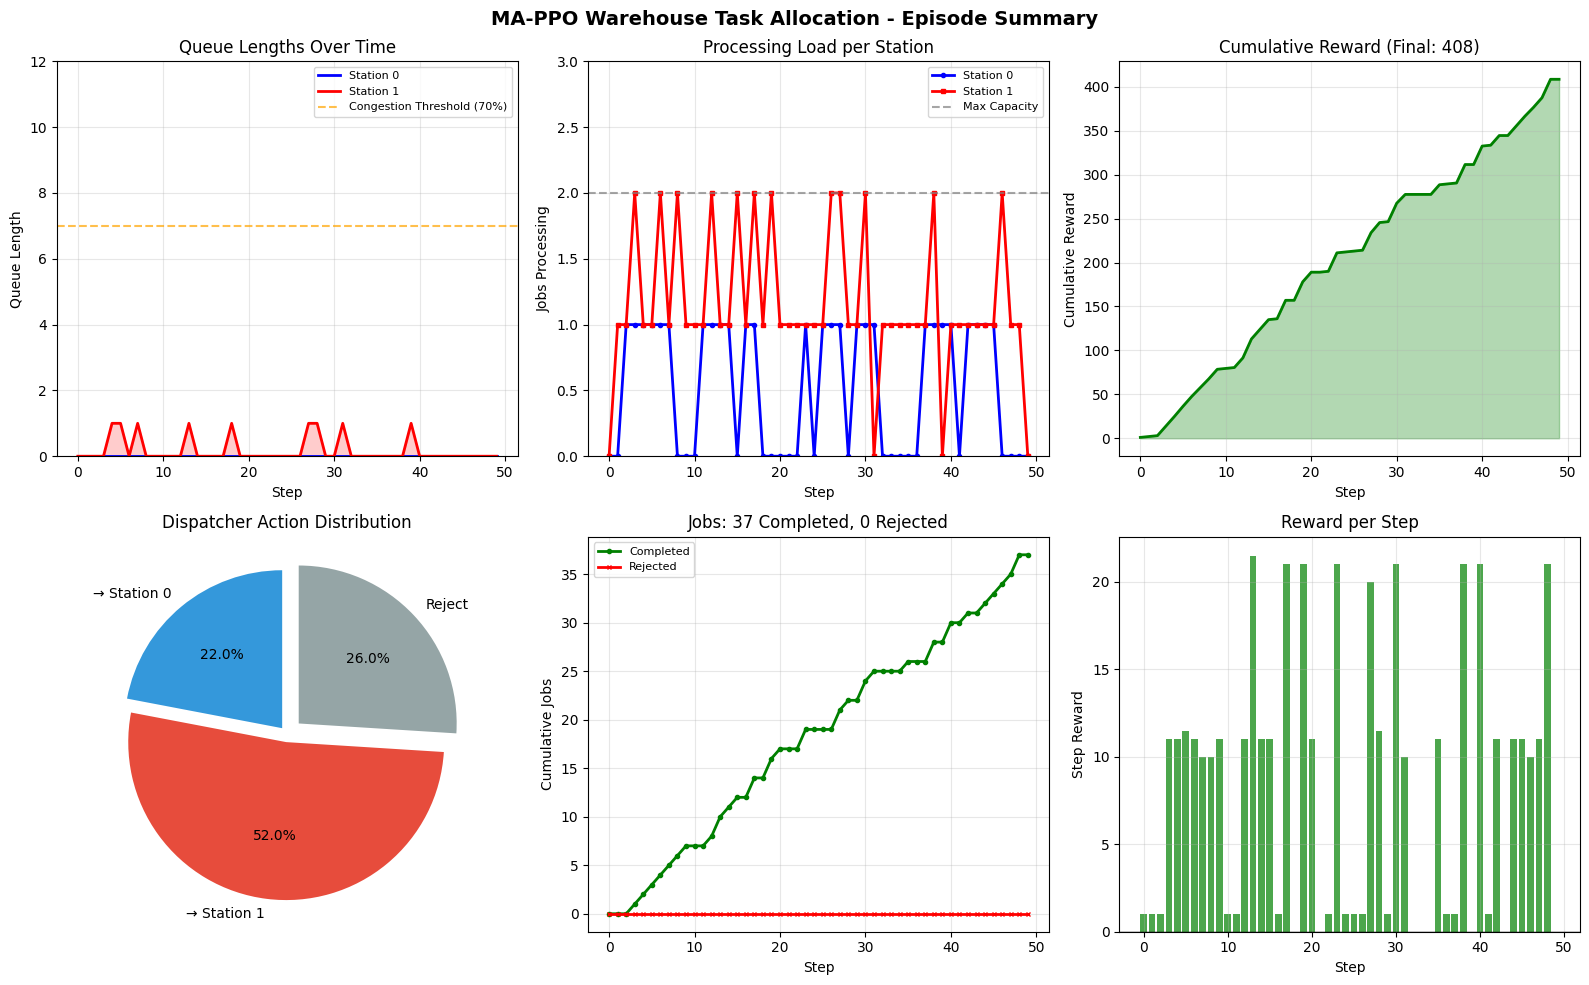

Creating animation... (this may take a minute)
✓ Animation saved to mappo_episode.gif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Files ready for download!


In [ ]:
# ============================================================
# WAREHOUSE ENVIRONMENT VISUALIZATION
# 
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import torch

# ============================================================
# EPISODE LOGGING FUNCTION
# ============================================================

def run_episode_with_logging(env, ma_system, seed=42):
    """
    Run one episode with the trained MA-PPO agent and log everything.
    Compatible with your FixedMultiAgentPPO class.
    """
    obs, info = env.reset(seed=seed)

    history = {
        'step': [],
        'queue_0': [],
        'queue_1': [],
        'processing_0': [],
        'processing_1': [],
        'pending_job': [],
        'dispatcher_action': [],
        'acceptor_0_action': [],
        'acceptor_1_action': [],
        'reward': [],
        'cumulative_reward': [],
        'jobs_completed': [],
        'jobs_rejected': []
    }

    cumulative_reward = 0

    for step in range(env.episode_length):
        mask = get_action_mask(env)

        # Greedy action selection (same as your evaluate function)
        with torch.no_grad():
            state_tensor = torch.FloatTensor(obs).unsqueeze(0).to(ma_system.device)

            # Dispatcher - greedy
            dispatcher_mask = ma_system._get_dispatcher_mask(mask)
            dispatcher_mask_tensor = torch.FloatTensor(dispatcher_mask).unsqueeze(0).to(ma_system.device)
            dispatcher_logits = ma_system.dispatcher_actor(state_tensor)
            dispatcher_probs = apply_action_mask_safe(dispatcher_logits, dispatcher_mask_tensor)
            dispatcher_action = torch.argmax(dispatcher_probs, dim=-1).item()

            # Acceptors - greedy
            acceptor_actions = [0, 0]
            if dispatcher_action < 2:
                target_station = dispatcher_action
                acceptor_mask = ma_system._get_acceptor_mask(mask, target_station)
                acceptor_mask_tensor = torch.FloatTensor(acceptor_mask).unsqueeze(0).to(ma_system.device)
                acceptor_logits = ma_system.acceptor_actors[target_station](state_tensor)
                acceptor_probs = apply_action_mask_safe(acceptor_logits, acceptor_mask_tensor)
                acceptor_actions[target_station] = torch.argmax(acceptor_probs, dim=-1).item()

        action_dict = {
            'dispatcher': dispatcher_action,
            'acceptor_0': acceptor_actions[0],
            'acceptor_1': acceptor_actions[1]
        }

        # Log state BEFORE taking action
        history['step'].append(step)
        history['queue_0'].append(len(env.station_queues[0]))
        history['queue_1'].append(len(env.station_queues[1]))
        history['processing_0'].append(len(env.station_processing[0]))
        history['processing_1'].append(len(env.station_processing[1]))
        history['pending_job'].append(1 if env.pending_job is not None else 0)
        history['dispatcher_action'].append(dispatcher_action)
        history['acceptor_0_action'].append(acceptor_actions[0])
        history['acceptor_1_action'].append(acceptor_actions[1])

        # Take step
        obs, reward, terminated, truncated, info = env.step(action_dict)
        cumulative_reward += reward

        history['reward'].append(reward)
        history['cumulative_reward'].append(cumulative_reward)
        history['jobs_completed'].append(info['total_jobs_completed'])
        history['jobs_rejected'].append(info['total_jobs_rejected'])

        if terminated or truncated:
            break

    return history, info


# ============================================================
# STATIC VISUALIZATION
# ============================================================

def create_episode_summary(history, save_path='mappo_episode_summary.png'):
    """Create a comprehensive static visualization of the episode"""

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle('MA-PPO Warehouse Task Allocation - Episode Summary',
                 fontsize=14, fontweight='bold')

    steps = history['step']

    # ===== Plot 1: Queue Lengths =====
    ax1 = axes[0, 0]
    ax1.plot(steps, history['queue_0'], 'b-', label='Station 0', linewidth=2)
    ax1.plot(steps, history['queue_1'], 'r-', label='Station 1', linewidth=2)
    ax1.axhline(y=7, color='orange', linestyle='--', alpha=0.7, label='Congestion Threshold (70%)')
    ax1.fill_between(steps, history['queue_0'], alpha=0.2, color='blue')
    ax1.fill_between(steps, history['queue_1'], alpha=0.2, color='red')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Queue Length')
    ax1.set_title('Queue Lengths Over Time')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 12)

    # ===== Plot 2: Processing Load =====
    ax2 = axes[0, 1]
    ax2.plot(steps, history['processing_0'], 'b-', label='Station 0', linewidth=2, marker='o', markersize=3)
    ax2.plot(steps, history['processing_1'], 'r-', label='Station 1', linewidth=2, marker='s', markersize=3)
    ax2.axhline(y=2, color='gray', linestyle='--', alpha=0.7, label='Max Capacity')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Jobs Processing')
    ax2.set_title('Processing Load per Station')
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 3)

    # ===== Plot 3: Cumulative Reward =====
    ax3 = axes[0, 2]
    ax3.fill_between(steps, history['cumulative_reward'], alpha=0.3, color='green')
    ax3.plot(steps, history['cumulative_reward'], 'g-', linewidth=2)
    ax3.set_xlabel('Step')
    ax3.set_ylabel('Cumulative Reward')
    final_reward = history['cumulative_reward'][-1]
    ax3.set_title(f'Cumulative Reward (Final: {final_reward:.0f})')
    ax3.grid(True, alpha=0.3)

    # ===== Plot 4: Dispatcher Actions Pie Chart =====
    ax4 = axes[1, 0]
    actions = history['dispatcher_action']
    action_counts = [actions.count(0), actions.count(1), actions.count(2)]
    labels = ['→ Station 0', '→ Station 1', 'Reject']
    colors = ['#3498db', '#e74c3c', '#95a5a6']
    explode = (0.05, 0.05, 0.1)

    # Only plot if there are actions
    if sum(action_counts) > 0:
        wedges, texts, autotexts = ax4.pie(action_counts, labels=labels, colors=colors,
                                            explode=explode, autopct='%1.1f%%', startangle=90)
        ax4.set_title('Dispatcher Action Distribution')
    else:
        ax4.text(0.5, 0.5, 'No actions', ha='center', va='center')

    # ===== Plot 5: Jobs Timeline =====
    ax5 = axes[1, 1]
    ax5.plot(steps, history['jobs_completed'], 'g-', label='Completed', linewidth=2, marker='o', markersize=3)
    ax5.plot(steps, history['jobs_rejected'], 'r-', label='Rejected', linewidth=2, marker='x', markersize=3)
    ax5.set_xlabel('Step')
    ax5.set_ylabel('Cumulative Jobs')
    final_completed = history['jobs_completed'][-1]
    final_rejected = history['jobs_rejected'][-1]
    ax5.set_title(f'Jobs: {final_completed} Completed, {final_rejected} Rejected')
    ax5.legend(loc='upper left', fontsize=8)
    ax5.grid(True, alpha=0.3)

    # ===== Plot 6: Step Rewards =====
    ax6 = axes[1, 2]
    rewards = history['reward']
    colors = ['green' if r >= 0 else 'red' for r in rewards]
    ax6.bar(steps, rewards, color=colors, alpha=0.7, width=0.8)
    ax6.axhline(y=0, color='black', linewidth=1)
    ax6.set_xlabel('Step')
    ax6.set_ylabel('Step Reward')
    ax6.set_title('Reward per Step')
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ Episode summary saved to {save_path}")
    plt.show()

    return fig


# ============================================================
# ANIMATED VISUALIZATION (GIF)
# ============================================================

def create_warehouse_animation(history, save_path='mappo_episode.gif', fps=2):
    """Create animated GIF visualization of the episode"""

    print("Creating animation... (this may take a minute)")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('MA-PPO Warehouse Task Allocation', fontsize=14, fontweight='bold')

    def animate(frame):
        for ax in axes.flatten():
            ax.clear()

        step = frame

        # ===== Top Left: Warehouse State Diagram =====
        ax1 = axes[0, 0]
        ax1.set_xlim(-0.5, 10)
        ax1.set_ylim(-0.5, 6)
        ax1.set_title(f'Step {step}: Warehouse State', fontweight='bold')
        ax1.set_aspect('equal')
        ax1.axis('off')

        # Draw Dispatcher
        dispatcher = patches.FancyBboxPatch((7, 2.5), 2, 1.5,
                                            boxstyle="round,pad=0.05",
                                            facecolor='#f39c12',
                                            edgecolor='black', linewidth=2)
        ax1.add_patch(dispatcher)
        ax1.text(8, 3.25, 'Dispatcher', ha='center', va='center', fontweight='bold', fontsize=9)

        # Draw stations
        for i, y_pos in enumerate([4.5, 1]):
            # Station box
            station = patches.FancyBboxPatch((0.5, y_pos), 3, 1.2,
                                             boxstyle="round,pad=0.05",
                                             facecolor='lightblue' if i == 0 else 'lightcoral',
                                             edgecolor='black', linewidth=2)
            ax1.add_patch(station)

            queue_len = history['queue_0'][step] if i == 0 else history['queue_1'][step]
            proc_count = history['processing_0'][step] if i == 0 else history['processing_1'][step]

            ax1.text(2, y_pos + 0.6, f'Station {i}', ha='center', va='center',
                    fontweight='bold', fontsize=10)
            ax1.text(2, y_pos + 0.2, f'Q:{queue_len} | P:{proc_count}', ha='center',
                    va='center', fontsize=9)

            # Queue visualization (dots)
            for j in range(min(queue_len, 5)):
                job_dot = patches.Circle((4 + j * 0.5, y_pos + 0.6), 0.15,
                                         facecolor='#3498db', edgecolor='black')
                ax1.add_patch(job_dot)

        # Pending job indicator
        if history['pending_job'][step]:
            pending = patches.Circle((9.2, 3.25), 0.25, facecolor='#2ecc71',
                                     edgecolor='black', linewidth=2)
            ax1.add_patch(pending)
            ax1.text(9.2, 3.8, 'JOB', ha='center', fontsize=7, fontweight='bold')

        # Action arrow
        action = history['dispatcher_action'][step]
        if action == 0:
            ax1.annotate('', xy=(3.5, 5.1), xytext=(7, 3.25),
                        arrowprops=dict(arrowstyle='->', color='green', lw=3))
        elif action == 1:
            ax1.annotate('', xy=(3.5, 1.6), xytext=(7, 3.25),
                        arrowprops=dict(arrowstyle='->', color='green', lw=3))
        else:
            ax1.text(8, 1.8, '✗ REJECT', ha='center', color='red', fontweight='bold', fontsize=10)

        # ===== Top Right: Queue Lengths =====
        ax2 = axes[0, 1]
        ax2.plot(history['queue_0'][:step+1], 'b-', label='Station 0', linewidth=2)
        ax2.plot(history['queue_1'][:step+1], 'r-', label='Station 1', linewidth=2)
        ax2.axhline(y=7, color='orange', linestyle='--', alpha=0.7)
        ax2.set_xlim(0, len(history['step']))
        ax2.set_ylim(0, 12)
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Queue Length')
        ax2.set_title('Queue Lengths')
        ax2.legend(loc='upper right', fontsize=8)
        ax2.grid(True, alpha=0.3)

        # ===== Bottom Left: Cumulative Reward =====
        ax3 = axes[1, 0]
        rewards = history['cumulative_reward'][:step+1]
        ax3.fill_between(range(len(rewards)), rewards, alpha=0.3, color='green')
        ax3.plot(rewards, 'g-', linewidth=2)
        ax3.set_xlim(0, len(history['step']))
        ax3.set_xlabel('Step')
        ax3.set_ylabel('Cumulative Reward')
        ax3.set_title(f'Cumulative Reward: {rewards[-1]:.0f}')
        ax3.grid(True, alpha=0.3)

        # ===== Bottom Right: Jobs Count =====
        ax4 = axes[1, 1]
        ax4.plot(history['jobs_completed'][:step+1], 'g-', label='Completed', linewidth=2)
        ax4.plot(history['jobs_rejected'][:step+1], 'r-', label='Rejected', linewidth=2)
        ax4.set_xlim(0, len(history['step']))
        ax4.set_xlabel('Step')
        ax4.set_ylabel('Jobs')
        ax4.set_title('Jobs Completed vs Rejected')
        ax4.legend(loc='upper left', fontsize=8)
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        return []

    anim = FuncAnimation(fig, animate, frames=len(history['step']),
                        interval=500, blit=False, repeat=True)

    # Save as GIF
    try:
        anim.save(save_path, writer='pillow', fps=fps)
        print(f"✓ Animation saved to {save_path}")
    except Exception as e:
        print(f"Warning: Could not save animation: {e}")
        print("Trying alternative save method...")
        try:
            anim.save(save_path, writer='imagemagick', fps=fps)
            print(f"✓ Animation saved to {save_path}")
        except:
            print("Could not save animation. Displaying instead...")

    plt.close()
    return anim


# ============================================================
# SIMPLE TEXT-BASED VISUALIZATION
# ============================================================

def print_episode_summary(history, info):
    """Print a text summary of the episode"""

    print("\n" + "=" * 60)
    print("EPISODE SUMMARY")
    print("=" * 60)

    print(f"\n📊 FINAL METRICS:")
    print(f"   Total Steps: {len(history['step'])}")
    print(f"   Jobs Completed: {history['jobs_completed'][-1]}")
    print(f"   Jobs Rejected: {history['jobs_rejected'][-1]}")
    print(f"   Final Reward: {history['cumulative_reward'][-1]:.0f}")

    # Action distribution
    actions = history['dispatcher_action']
    print(f"\n DISPATCHER ACTIONS:")
    print(f"   → Station 0: {actions.count(0)} times ({100*actions.count(0)/len(actions):.1f}%)")
    print(f"   → Station 1: {actions.count(1)} times ({100*actions.count(1)/len(actions):.1f}%)")
    print(f"   ✗ Reject:    {actions.count(2)} times ({100*actions.count(2)/len(actions):.1f}%)")

    # Queue stats
    print(f"\n QUEUE STATISTICS:")
    print(f"   Station 0 - Max: {max(history['queue_0'])}, Avg: {np.mean(history['queue_0']):.1f}")
    print(f"   Station 1 - Max: {max(history['queue_1'])}, Avg: {np.mean(history['queue_1']):.1f}")

    # Reward breakdown
    positive_rewards = sum(r for r in history['reward'] if r > 0)
    negative_rewards = sum(r for r in history['reward'] if r < 0)
    print(f"\n REWARD BREAKDOWN:")
    print(f"   Positive: +{positive_rewards:.0f}")
    print(f"   Negative: {negative_rewards:.0f}")
    print(f"   Net:      {history['cumulative_reward'][-1]:.0f}")

    print("\n" + "=" * 60)


# ============================================================
# RUN VISUALIZATION
# ============================================================

# Make sure you have trained your MA-PPO agent first (ma_ppo and env_marl should exist)

print("\n" + "=" * 60)
print("RUNNING VISUALIZATION FOR MA-PPO AGENT")
print("=" * 60)

# Run episode and collect data
history, final_info = run_episode_with_logging(env_marl, ma_ppo, seed=42)

# Print text summary (always works)
print_episode_summary(history, final_info)

# Create static visualization
create_episode_summary(history, 'mappo_episode_summary.png')

# Create animated GIF (may take a minute)
create_warehouse_animation(history, 'mappo_episode.gif', fps=2)

# Download files in Colab
try:
    from google.colab import files
    files.download('mappo_episode_summary.png')
    files.download('mappo_episode.gif')
    print("\n✓ Files ready for download!")
except:
    print("\nFiles saved locally (not in Colab)")

In [ ]:
# Diagnostic: Check what masks are being generated
env_test = WarehouseTaskAllocationEnv()
obs, info = env_test.reset(seed=42)

for step in range(10):
    mask = get_action_mask(env_test)

    # Check dispatcher mask derivation
    station_0_valid = any(mask[i] == 1 for i in [0, 1, 2, 3])
    station_1_valid = any(mask[i] == 1 for i in [4, 5, 6, 7])

    print(f"Step {step}: Full mask = {mask}")
    print(f"  Station 0 valid: {station_0_valid}, Station 1 valid: {station_1_valid}")
    print(f"  Pending job: {env_test.pending_job is not None}")
    print(f"  Queue 0: {len(env_test.station_queues[0])}, Queue 1: {len(env_test.station_queues[1])}")
    print()

    # Take random valid action
    action = {'dispatcher': 1 if station_1_valid else 2, 'acceptor_0': 1, 'acceptor_1': 1}
    obs, r, term, trunc, info = env_test.step(action)

    if term or trunc:
        break

✓ Environment initialized!
  Architecture: 1 Dispatcher + 2 Acceptors
   Observation space: (7,)
   Dispatcher: 3 actions
   Each Acceptor: 2 actions
Step 0: Full mask = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  Station 0 valid: True, Station 1 valid: True
  Pending job: True
  Queue 0: 0, Queue 1: 0

Step 1: Full mask = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  Station 0 valid: True, Station 1 valid: True
  Pending job: True
  Queue 0: 0, Queue 1: 0

Step 2: Full mask = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  Station 0 valid: True, Station 1 valid: True
  Pending job: True
  Queue 0: 0, Queue 1: 0

Step 3: Full mask = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  Station 0 valid: True, Station 1 valid: True
  Pending job: True
  Queue 0: 0, Queue 1: 1

Step 4: Full mask = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  Station 0 valid: True, Station 1 valid: True
  Pending job: True
  Queue 0: 0, Queue 1: 2

Step 5: Full mask = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  Station 0 valid: True, Station 1 va

# REFERENCES


Primary Inspiration:
[1] Ali, A.M., Tirel, L., & Hashim, H.A. (2025). "Novel Multi-Agent Action Masked Deep Reinforcement Learning for General Industrial Assembly Lines Balancing Problems." Journal of Automation and Intelligence.

Core Algorithms:
[2] Mnih, V., et al. (2015). "Human-level control through deep reinforcement learning." Nature, 518(7540), 529-533. → DQN: Deep Q-Network
[3] Schulman, J., et al. (2017). "Proximal Policy Optimization Algorithms." arXiv:1707.06347. → PPO: Clipped surrogate objective
[4] Sutton, R.S. & Barto, A.G. (2018). "Reinforcement Learning: An Introduction." MIT Press. → Foundational RL concepts

Multi-Agent RL:
[5] Lowe, R., et al. (2017). "Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments." NeurIPS. → MADDPG: Centralized critic concept
[6] Yu, C., et al. (2022). "The Surprising Effectiveness of PPO in Cooperative Multi-Agent Games." NeurIPS. → MAPPO performance analysis

Tools & Libraries:
[7] Gymnasium (Farama Foundation) - https://gymnasium.farama.org/ → Environment API
[8] PyTorch - https://pytorch.org/ → Neural network implementation
[9] PettingZoo - https://pettingzoo.farama.org/ → Multi-agent environment benchmark

Course:
[10] CSE 546: Reinforcement Learning, Fall 2025 Instructor: Dr. Alina Vereshchaka University at Buffalo
